In [1]:
import os
import sys
import pickle
import numpy as np
from scipy.sparse import csc_matrix, kron, identity
from scipy.sparse.linalg import expm
from matplotlib import pyplot as plt
large = 40; med = 30; small = 10
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["text.usetex"] = True
plt.rcParams.update(params)

# Optimization class

In [2]:
class NonUnitaryVQE:
     """
     An optimized implementation of a Non-Unitary Variational Quantum Eigensolver.

     This version addresses performance bottlenecks in the gradient and Hessian
     calculations, making it significantly faster for models with multiple layers.
     """
     # --- Pauli and identities (defined once as class attributes) ---
     I2 = csc_matrix(np.eye(2, dtype=complex))
     I4 = identity(4, dtype=complex, format='csc')
     X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
     Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
     Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

     def __init__(self, Delta: float, gamma_depol: float, use_dissipators: bool, softplus: bool = True, negative_infinity: float = 0.0, freeze_params: bool = False):
          """
          Initializes the VQE simulation.

          Args:
               Delta (float): Field strength.
               gamma_depol (float): Depolarizing noise strength.
               use_dissipators (bool): If True, dissipative channels are included.
               softplus (bool): If True, use softplus to enforce positive dissipative angles.
               negative_infinity (float): A small value to effectively zero out dissipative params when not used.
               freeze_params (bool): If True, only trains the parameters of the last layer.
          """
          self.Delta = Delta
          self.gamma_depol = gamma_depol
          self.use_dissipators = use_dissipators
          self.n_params = 4  # [θ1=f(Z), θ2=exc, θ3=int(X), θ4=dep]
          self.softplus = softplus
          self.negative_infinity = negative_infinity
          self.freeze_params = freeze_params

          # Jump operators are only defined if dissipators are active.
          if self.use_dissipators:
               self.L1_op = (self.X - 1j * self.Y) / 2
               self.L2_op = (self.I2 + self.Z) / 2
          else:
               # Use zero matrices if dissipators are off for cleaner logic later.
               self.L1_op = csc_matrix((2, 2), dtype=complex)
               self.L2_op = csc_matrix((2, 2), dtype=complex)

          # Pre-calculate the depolarizing superoperator as it's constant.
          self.D = self._get_D_super()

          # Lists to hold values during optimization.
          self.angles_history = []
          self.cost_history = []
          self.gradients_history = []
          self.rho_history = []
          self.x_history = []
          self.y_history = []
          self.z_history = []
          self.best_angles = None
          self.best_cost = -np.inf

     # --- Helper Methods for Matrix Operations ---
     @staticmethod
     def _vectorize(rho):
          """Vectorizes a density matrix (column-stacking)."""
          return rho.flatten(order="F")[:, None]

     @staticmethod
     def _unvectorize(rho_vec):
          """Reshapes a vectorized density matrix back to a 2x2 matrix."""
          return rho_vec.reshape((2, 2), order="F")

     def _bloch(self, rho_mat):
          """Calculates Bloch components (x, y, z) from a density matrix."""
          x = np.real(np.trace(self.X @ rho_mat))
          y = np.real(np.trace(self.Y @ rho_mat))
          z = np.real(np.trace(self.Z @ rho_mat))
          return x, y, z

     # --- Superoperator Definitions ---
     def _L_depol_super(self):
          """Superoperator for the depolarizing channel."""
          term_x = kron(self.X.conj(), self.X, format='csc')
          term_y = kron(self.Y.conj(), self.Y, format='csc')
          term_z = kron(self.Z.conj(), self.Z, format='csc')
          term_I = kron(self.I2, self.I2, format='csc')
          return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

     def _get_D_super(self):
          """Returns the exponentiated depolarizing superoperator."""
          if abs(self.gamma_depol) < 1e-16:
               return self.I4
          return expm(self._L_depol_super())

     def _L_Z(self):
          """Liouvillian for the Z field term."""
          H = self.Z
          return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

     def _L_int(self, x_mean):
          """Liouvillian for the mean-field X interaction term."""
          H = x_mean * self.X
          return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

     def _L_exc(self):
          """Liouvillian for the excitation jump channel."""
          L = self.L1_op
          LdL = L.conj().T @ L
          return kron(L.conj(), L) - 0.5 * (kron(self.I2, LdL) + kron(LdL.T, self.I2))

     def _L_dep(self):
          """Liouvillian for the dephasing jump channel."""
          L = self.L2_op
          LdL = L.conj().T @ L
          return kron(L.conj(), L) - 0.5 * (kron(self.I2, LdL) + kron(LdL.T, self.I2))

     # --- Cost Function and Ansatz ---
     def _H(self, x_val):
          """Mean-field Hamiltonian for a single qubit."""
          return x_val * self.X - self.Delta * self.Z

     def _cost(self, rho_final_mat, x_final):
          """Calculates the energy expectation value."""
          Hf = self._H(x_final)
          return np.real(np.trace(Hf @ rho_final_mat))

     def _variational_forward(self, n_layers, angles, rho0_vec):
          """
          Computes the forward pass of the VQE, applying all layers.

          This function calculates the final state and caches intermediate states
          and operators, which are essential for efficient gradient calculation.

          Returns:
               tuple: Contains final state, evolvers, propagators, and history
                      of states and x-values.
          """
          rho_vec = rho0_vec.copy()
          
          # History lists for storing intermediate values needed for gradients
          rho_history = [rho_vec]
          x_history = []
          pre_int_history = []
          evolvers = ([], [], [], []) # E_f, E_exc, E_int, E_dep
          propagators = []

          for l in range(n_layers):
               th_f, th_exc_a, th_int, th_dep_a = angles[l]

               # Ensure dissipative parameters are positive
               if self.softplus:
                    th_exc = np.log(1 + np.exp(th_exc_a))
                    th_dep = np.log(1 + np.exp(th_dep_a))
               else:
                    th_exc = np.exp(th_exc_a)
                    th_dep = np.exp(th_dep_a)

               # Get x_mean from the state before applying the current layer
               x_current, _, _ = self._bloch(self._unvectorize(rho_vec))
               x_history.append(x_current)

               # Build operators for the current layer
               E_f = expm(th_f * self._L_Z().tocsr())
               E_exc = expm(th_exc * self._L_exc().tocsr()) if self.use_dissipators else self.I4
               
               # To build E_int, we need the x-value from the state *just before* the X-block
               rho_pre_int_vec = self.D @ E_exc @ self.D @ E_f @ self.D @ rho_vec
               pre_int_history.append(rho_pre_int_vec)
               x_pre_int, _, _ = self._bloch(self._unvectorize(rho_pre_int_vec))
               
               E_int = expm(th_int * self._L_int(x_pre_int).tocsr())
               E_dep = expm(th_dep * self._L_dep().tocsr()) if self.use_dissipators else self.I4

               # Combine all operators into a single propagator for the layer
               # M_l = D E_dep D E_int D E_exc D E_f D
               M = self.D @ E_dep @ self.D @ E_int @ self.D @ E_exc @ self.D @ E_f @ self.D
               
               # Evolve the state vector
               rho_vec = M @ rho_vec
               
               # Optional: Check for trace preservation and re-normalize
               rho_mat_temp = self._unvectorize(rho_vec)
               tr = np.trace(rho_mat_temp)
               if abs(tr - 1) > 0.15: # Tolerance for trace deviation
                    print(f"Warning: Trace deviation at layer {l+1}. Trace = {tr.real}")
                    # Re-normalize to maintain stability
                    rho_vec /= tr

               # Store results for this layer
               rho_history.append(rho_vec)
               evolvers[0].append(E_f)
               evolvers[1].append(E_exc)
               evolvers[2].append(E_int)
               evolvers[3].append(E_dep)
               propagators.append(M)

          # Final x-value
          x_final, _, _ = self._bloch(self._unvectorize(rho_vec))
          x_history.append(x_final)
          
          return rho_vec, evolvers, propagators, rho_history, x_history, pre_int_history

     def _calc_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, pre_int_history):
          """
          Calculates gradients efficiently using a single backward pass.
          This implementation has O(n) complexity instead of O(n^2).
          """
          grads = [[0.0] * self.n_params for _ in range(n_layers)]
          x_final = x_history[-1]
          
          # Helper function to compute gradient component from a state derivative
          def grad_from_drho(d_rho_final_vec):
               d_rho_final_mat = self._unvectorize(d_rho_final_vec)
               # Gradient of cost C = Tr[H_f * rho_f] is Tr[ (dC/d(rho_f)) * (d(rho_f)/d(theta)) ]
               # dC/d(rho_f) = H_f^T = (2*x_f*X - Delta*Z)^T
               H_grad_op = 2 * x_final * self.X - self.Delta * self.Z
               return np.real(np.trace(H_grad_op.T @ d_rho_final_mat))

          # We will precompute the left side propagators for efficiency.
          # The list propagators is [M_1, M_2, ....., M_L]. It does not have $rho_{0}$.
          # We need P_lefts[l] = M_L * M_(L-1) * ..... * M_(l+1).
          # This loop constructs P_lefts = [P_lefts[L], P_lefts[L-1], ....., P_lefts[0]].
          # A total of L+1 elements, where P_lefts[L] = I (identity).
          P_lefts = [self.I4] * (n_layers + 1)
          for l_idx in range(n_layers - 1, -1, -1):
               P_lefts[l_idx] = P_lefts[l_idx+1] @ propagators[l_idx]

          for l in range(n_layers):
               E_f, E_exc, E_int, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]
               
               # Propagator for layers *after* l
               P_after_l = P_lefts[l+1]

               # --- Gradient for θ1 (Z field) ---
               rho_post_f = E_f @ (self.D @ rho_history[l])
               d_local = self._L_Z() @ rho_post_f
               # Ansatz left to the derivative.
               tail = self.D @ E_dep @ self.D @ E_int @ self.D @ E_exc @ self.D
               d_rho_final = P_after_l @ tail @ d_local
               grads[l][0] = grad_from_drho(d_rho_final)

               # --- Gradient for θ2 (Excitation) ---
               if self.use_dissipators:
                    rho_post_exc = E_exc @ (self.D @ E_f @ self.D @ rho_history[l])
                    d_local = self._L_exc() @ rho_post_exc
                    tail = self.D @ E_dep @ self.D @ E_int @ self.D
                    d_rho_final = P_after_l @ tail @ d_local
                    grads[l][1] = grad_from_drho(d_rho_final)

               # --- Gradient for θ3 (X interaction) ---
               # Need the state just before the X-block.
               rho_pre_int_vec = pre_int_history[l]
               # Extract x_pre_int from this density matrix.
               x_pre_int, _, _ = self._bloch(self._unvectorize(rho_pre_int_vec))
               
               rho_post_int_mat = self._unvectorize(E_int @ rho_pre_int_vec)
               deriv_mat_local = -1j * x_pre_int * (self.X @ rho_post_int_mat - rho_post_int_mat @ self.X)

               d_local = self._vectorize(deriv_mat_local)
               tail = self.D @ E_dep @ self.D # Operators after X-block in layer l
               d_rho_final = P_after_l @ (tail @ d_local)
               grads[l][2] = grad_from_drho(d_rho_final)

               # --- Gradient for θ4 (Dephasing) ---
               if self.use_dissipators:
                    rho_post_dep = E_dep @ (self.D @ E_int @ self.D @ E_exc @ self.D @ E_f @ self.D @ rho_history[l])
                    d_local = self._L_dep() @ rho_post_dep
                    tail = self.D
                    d_rho_final = P_after_l @ tail @ d_local
                    grads[l][3] = grad_from_drho(d_rho_final)

          return grads

     # --------------------------- Main Training Loop ------------------------
     def run_vqa(self, n_layers, rho_initial_mat, initial_angles, lr, iters, lr_decay=1.0, tol=1e-6, clip=np.inf):
          """
          Executes the Variational Quantum Algorithm.

          Args:
               n_layers (int): Number of layers in the ansatz.
               rho_initial_mat (csc_matrix): The starting density matrix.
               initial_angles (list of lists): Initial parameters for each layer.
               lr (float): Learning rate for the optimizer.
               iters (int): Maximum number of optimization iterations.
               lr_decay (float): Multiplicative factor for learning rate decay.
               tol (float): Convergence tolerance based on cost change.
               clip (float): Maximum norm for gradient clipping.
          """
          # FIX: Use the sparse matrix's own .trace() method instead of np.trace()
          rho0_vec = self._vectorize((rho_initial_mat / rho_initial_mat.trace()).toarray())
          angles = [list(a) for a in initial_angles]
          
          # Initialize history and best-found values
          self.cost_history.clear(); self.gradients_history.clear()
          self.rho_history = [self._unvectorize(rho0_vec)]
          self.x_history.clear(); self.y_history.clear(); self.z_history.clear()
          x0, y0, z0 = self._bloch(self._unvectorize(rho0_vec))
          self.x_history.append(x0); self.y_history.append(y0); self.z_history.append(z0)

          print(f"Starting VQA for {n_layers} layers. Dissipators: {self.use_dissipators}")

          for it in range(1, iters + 1):
               # --- Forward Pass ---
               rho_final_vec, evolvers, propagators, rho_hist, x_hist, pre_int_hist = \
                    self._variational_forward(n_layers, angles, rho0_vec)
               
               rho_final_mat = self._unvectorize(rho_final_vec)
               x_final, y_final, z_final = self._bloch(rho_final_mat)
               cost = self._cost(rho_final_mat, x_final)

               # --- Logging and History Tracking ---
               self.cost_history.append(cost)
               self.x_history.append(x_final); self.y_history.append(y_final); self.z_history.append(z_final)
               self.rho_history.append(rho_final_mat)
               self.angles_history.append([list(a) for a in angles])

               norm = np.sqrt(x_final**2 + y_final**2 + z_final**2)
               print(f"Iter {it:03d} | Cost = {cost:.8f} | Bloch Norm = {norm:.6f}")
               
               if norm > 1.0 + 1e-9:
                    print("Warning: Bloch vector norm > 1. Stopping.")
                    break

               # --- Check for Convergence ---
               if cost > self.best_cost:
                    self.best_cost = cost
                    self.best_angles = [list(a) for a in angles]

               if it > 2 and abs(self.cost_history[-1] - self.cost_history[-2]) < tol:
                    print(f"Converged at iter {it} with tolerance {tol}.")
                    break

               # --- Gradient Calculation and Parameter Update ---
               grads = self._calc_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, pre_int_hist)
               self.gradients_history.append(grads)

               # Gradient clipping
               gnorm = np.linalg.norm(np.array(grads))
               if gnorm > clip:
                    grads = (np.array(grads) * (clip / gnorm)).tolist()
                    print(f"Gradient clipped from {gnorm:.4f} to {clip:.4f}")

               # Determine which layers to update
               layers_to_update = range(n_layers)
               if self.freeze_params and n_layers > 0:
                    layers_to_update = [n_layers - 1]

               # Apply updates
               for l in layers_to_update:
                    # Update unitary parameters
                    angles[l][0] += lr * grads[l][0]
                    angles[l][2] += lr * grads[l][2]                

                    # Update dissipative parameters
                    if self.use_dissipators:
                         if self.softplus:
                              # Derivative of softplus is sigmoid
                              grad_mult_exc = 1 / (1 + np.exp(-angles[l][1]))
                              grad_mult_dep = 1 / (1 + np.exp(-angles[l][3]))
                              angles[l][1] += lr * grads[l][1] * grad_mult_exc
                              angles[l][3] += lr * grads[l][3] * grad_mult_dep
                         else: # Exponential parameterization
                              th_exc = np.exp(angles[l][1])
                              th_dep = np.exp(angles[l][3])
                              angles[l][1] += lr * grads[l][1] * th_exc
                              angles[l][3] += lr * grads[l][3] * th_dep
                    else:
                         # Ensure dissipative angles are zeroed out
                         angles[l][1] = self.negative_infinity
                         angles[l][3] = self.negative_infinity    
               print(f"Angles: {angles}")                

               # Decay learning rate
               lr *= lr_decay
          
          return (self.angles_history, self.best_angles, self.best_cost, self.cost_history,
                    self.rho_history, self.gradients_history)

# Optimization using $L$ layers

In [3]:
N_LAYERS = 3
DELTA = 0.5
GAMMA_DEPOL = 0.01
USE_DISSIPATORS = True

x0 = 0.0
y0 = 1.0
if np.sqrt(1 - x0**2 - y0**2) > 1:
     raise ValueError(r"\sqrt{x^{2} + y^{2}} exceed one.")
z0 = np.sqrt(1 - x0**2 - y0**2)
rho0 = (NonUnitaryVQE.I2 + x0*NonUnitaryVQE.X + y0*NonUnitaryVQE.Y + z0*NonUnitaryVQE.X) / 2
# rho0 = (NonUnitaryVQE.I2 + NonUnitaryVQE.Y) / 2 
initial_angles = [[0.1 * np.random.random(), 0.0, 0.1 * np.random.random(), 0.0] for _ in range(N_LAYERS)]

# Initialize the VQE model
vqe = NonUnitaryVQE(
     Delta=DELTA,
     gamma_depol=GAMMA_DEPOL,
     use_dissipators=USE_DISSIPATORS,
     softplus=True
)

# Run the optimization
angles_hist, best_angles, best_cost, cost_hist, rho_hist, grad_hist = vqe.run_vqa(
     n_layers=N_LAYERS,
     rho_initial_mat=rho0,
     initial_angles=initial_angles,
     lr=1.0,
     iters=2000,
     lr_decay=1.0,
     tol=1e-7
)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_15334/3848736646.py:9: SyntaxWarning: invalid escape sequence '\s'
  raise ValueError("\sqrt{x^{2} + y^{2}} exceed one.")
/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


Starting VQA for 3 layers. Dissipators: True
Iter 001 | Cost = 0.35125980 | Bloch Norm = 0.704865
Angles: [[np.float64(0.09283830979278647), np.float64(0.018079037415770757), np.float64(0.09013386077187528), np.float64(-0.00027829074246458205)], [np.float64(0.043527218967752135), np.float64(0.02610771156522143), np.float64(0.05788557639122528), np.float64(-0.0001997862624560006)], [np.float64(0.01381119121898042), np.float64(0.04612983129985844), np.float64(0.05025917109919575), np.float64(-0.00016936154325537255)]]
Iter 002 | Cost = 0.35463283 | Bloch Norm = 0.711302
Angles: [[np.float64(0.09723992027577519), np.float64(0.035418286551403055), np.float64(0.10035637625288149), np.float64(-0.0005933434550360814)], [np.float64(0.04820176202690775), np.float64(0.05132797453140529), np.float64(0.06370723368600759), np.float64(-0.00042632989811788814)], [np.float64(0.01857101683262529), np.float64(0.09160042799212731), np.float64(0.052818045725464544), np.float64(-0.00036294676722723547)]]
I

In [4]:
rho_b = rho_hist[-1]
xb = np.real(np.trace(NonUnitaryVQE.X @ rho_b))
yb = np.real(np.trace(NonUnitaryVQE.Y @ rho_b))
zb = np.real(np.trace(NonUnitaryVQE.Z @ rho_b))
print(f"Final Bloch vector: x={xb:.10f}, y={yb:.10f}, z={zb:.10f}, norm={np.sqrt(xb**2 + yb**2 + zb**2):.10f}")

Final Bloch vector: x=-0.0019192715, y=0.0002044873, z=-0.8859231389, norm=0.8859252415


# Optimization using $L + 1$ layers

In [5]:
n_layers = 4
initial_angles = [[0.1 * np.random.random(), 0, 0.1 * np.random.random(), 0] for _ in range(n_layers)]

# Initialize the VQE model
vqe = NonUnitaryVQE(
     Delta=DELTA,
     gamma_depol=GAMMA_DEPOL,
     use_dissipators=USE_DISSIPATORS,
     softplus=True
)

# Run the optimization
angles_hist_L_1, best_angles_L_1, best_cost_L_1, floquet_cost_hist, rho_hist_L_1, grad_hist_L_1 = vqe.run_vqa(
     n_layers=n_layers,
     rho_initial_mat=rho0,
     initial_angles=initial_angles,
     lr=1.0,
     iters=2000,
     lr_decay=1.0,
     tol=1e-7
)

print("\n--- Results ---")
print(f"Best cost (energy): {best_cost}")
print("Best angles:")
for i, a in enumerate(best_angles):
     print(f"  Layer {i+1}: {np.round(a, 4)}")

Starting VQA for 4 layers. Dissipators: True
Iter 001 | Cost = 0.36524071 | Bloch Norm = 0.730658
Angles: [[np.float64(0.0747734832021804), np.float64(0.007468322949459277), np.float64(0.0365262013923834), np.float64(-0.00010580032821614461)], [np.float64(0.06652921885224097), np.float64(0.010807593246029576), np.float64(0.027921601204569883), np.float64(-8.848568769113501e-05)], [np.float64(0.006866289550487655), np.float64(0.019018397445460387), np.float64(0.0075376738112785825), np.float64(-8.656059262417589e-05)], [np.float64(0.09738703905751435), np.float64(0.039113170573067735), np.float64(0.021137561109466838), np.float64(-8.306941902663616e-05)]]
Iter 002 | Cost = 0.36732085 | Bloch Norm = 0.734794
Angles: [[np.float64(0.075921973628324), np.float64(0.014672458390482406), np.float64(0.03998945343147448), np.float64(-0.00021291815215149172)], [np.float64(0.0677097066658746), np.float64(0.021263222676678774), np.float64(0.030434436904978036), np.float64(-0.00017695555998158992)],

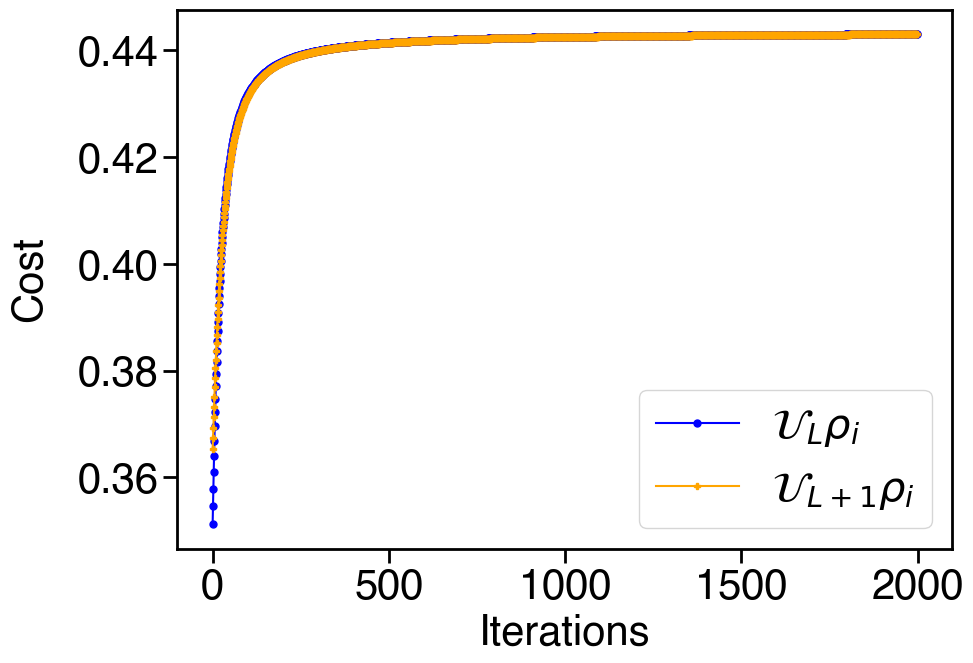

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))

makersize = 5
cost1 = cost_hist
cost2 = floquet_cost_hist

plt.plot(np.arange(len(cost1)), cost1, marker='o', markersize=makersize, label=r'$\mathcal{U}_{L}\rho_{i}$', color='blue')
plt.plot(np.arange(len(cost2)), cost2, marker='P', markersize=makersize, label=r'$\mathcal{U}_{L + 1}\rho_{i}$', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Cost', labelpad = 20)
plt.legend()
for spline in ax.spines.values():
        spline.set_linewidth(2)
        ax.tick_params(axis='both', which='both', length=10, width=2)
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/figures/'
# os.chdir(path)
# plt.savefig(f'dissipative_floquet_n_layers_{n_layers}_cost_history_comparison_unitary_best_rho.png', dpi=600, bbox_inches='tight')      
plt.show()

Final Bloch vector (L=1): x=-0.0008788260, y=0.0004749900, z=-0.8859229775, norm=0.8859235407


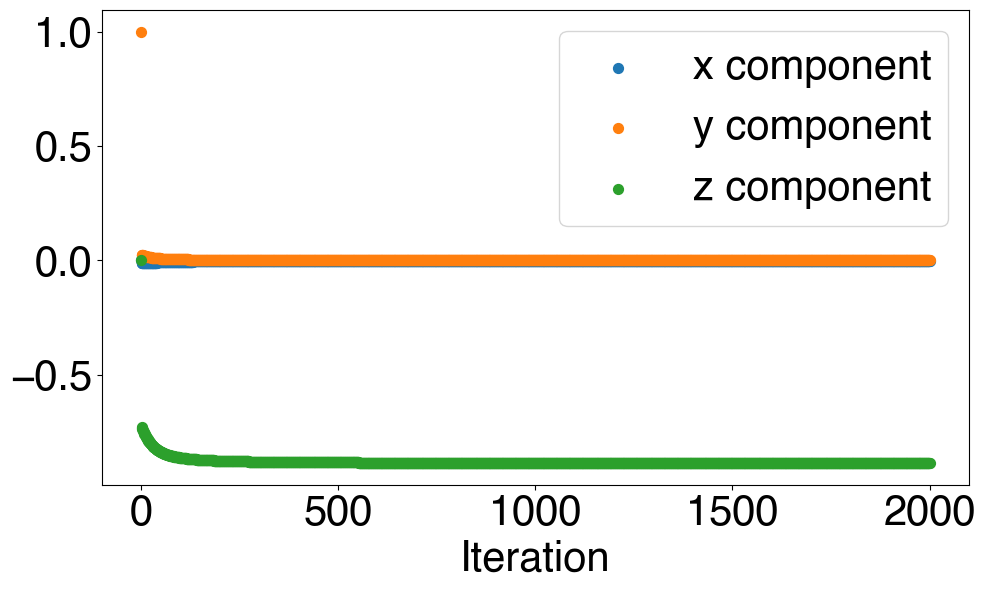

In [7]:
# Plot x, y, z components of the Bloch vector for each iteration in rho_hist_L_1

x_L_1 = []
y_L_1 = []
z_L_1 = []

for rho in rho_hist_L_1:
     x_val = np.real(np.trace(NonUnitaryVQE.X @ rho))
     y_val = np.real(np.trace(NonUnitaryVQE.Y @ rho))
     z_val = np.real(np.trace(NonUnitaryVQE.Z @ rho))
     x_L_1.append(x_val)
     y_L_1.append(y_val)
     z_L_1.append(z_val)

print(f"Final Bloch vector (L=1): x={x_L_1[-1]:.10f}, y={y_L_1[-1]:.10f}, z={z_L_1[-1]:.10f}, norm={np.sqrt(x_L_1[-1]**2 + y_L_1[-1]**2 + z_L_1[-1]**2):.10f}")

plt.figure(figsize=(10, 6))
plt.scatter(range(len(x_L_1)), x_L_1, label='x component', color='C0', s=50)
plt.scatter(range(len(y_L_1)), y_L_1, label='y component', color='C1', s=50)
plt.scatter(range(len(z_L_1)), z_L_1, label='z component', color='C2', s=50)
plt.xlabel('Iteration')
# plt.ylabel('Bloch vector component')
plt.legend()
plt.tight_layout()
plt.show()

# Floquet super operator

In [40]:
# Constructs Floquet super operator with best angles

def construct_floquet_super(best_angles, best_rho, Delta, gamma_depol, use_dissipators):
     vqe = NonUnitaryVQE(Delta=Delta, gamma_depol=gamma_depol, use_dissipators=use_dissipators, softplus=True)
     D = vqe.D

     th_f, th_exc_a, th_int, th_dep_a = best_angles

     if vqe.softplus:
          th_exc = np.log(1 + np.exp(th_exc_a))
          th_dep = np.log(1 + np.exp(th_dep_a))
     else:
          th_exc = np.exp(th_exc_a)
          th_dep = np.exp(th_dep_a)
          
     """ 
     We do not need to calculate density matrix to calculate Floquet super operator.
     But to calculate E_int term, we need to extract x_mid from the density matrix.
     """
     # Initialize density matrix.     
     E_f = expm(th_f * vqe._L_Z().tocsr())
     E_exc = expm(th_exc * vqe._L_exc().tocsr()) if use_dissipators else vqe.I4

     # Calculating x value from density matrix until this step.
     rho = vqe._vectorize(best_rho)     
     rho = E_f @ D @ rho     
     rho = D @ E_exc @ D @ rho
     # Extract x_mid from density matrix at this point.
     x_mid, _, _ = vqe._bloch(vqe._unvectorize(rho))

     E_int = expm(th_int * vqe._L_int(x_mid).tocsr())
     E_dep = expm(th_dep * vqe._L_dep().tocsr()) if use_dissipators else vqe.I4

     # Construct the full Floquet superoperator.
     # self.D @ E_dep @ self.D @ E_int @ self.D @ E_exc @ self.D @ E_f @ self.D
     floquet_super = D @ E_dep @ D @ E_int @ D @ E_exc @ D @ E_f @ D
     return floquet_super

angle_from_last_layer = (np.array(angles_hist_L_1)[-1][-1:,]).tolist()[0]
rho_best = rho_hist_L_1[-1]
floquet_super = construct_floquet_super(angle_from_last_layer, rho_best, DELTA, GAMMA_DEPOL, USE_DISSIPATORS)

/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/sasankadowarah/opt/anaconda3/envs/latest_python/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


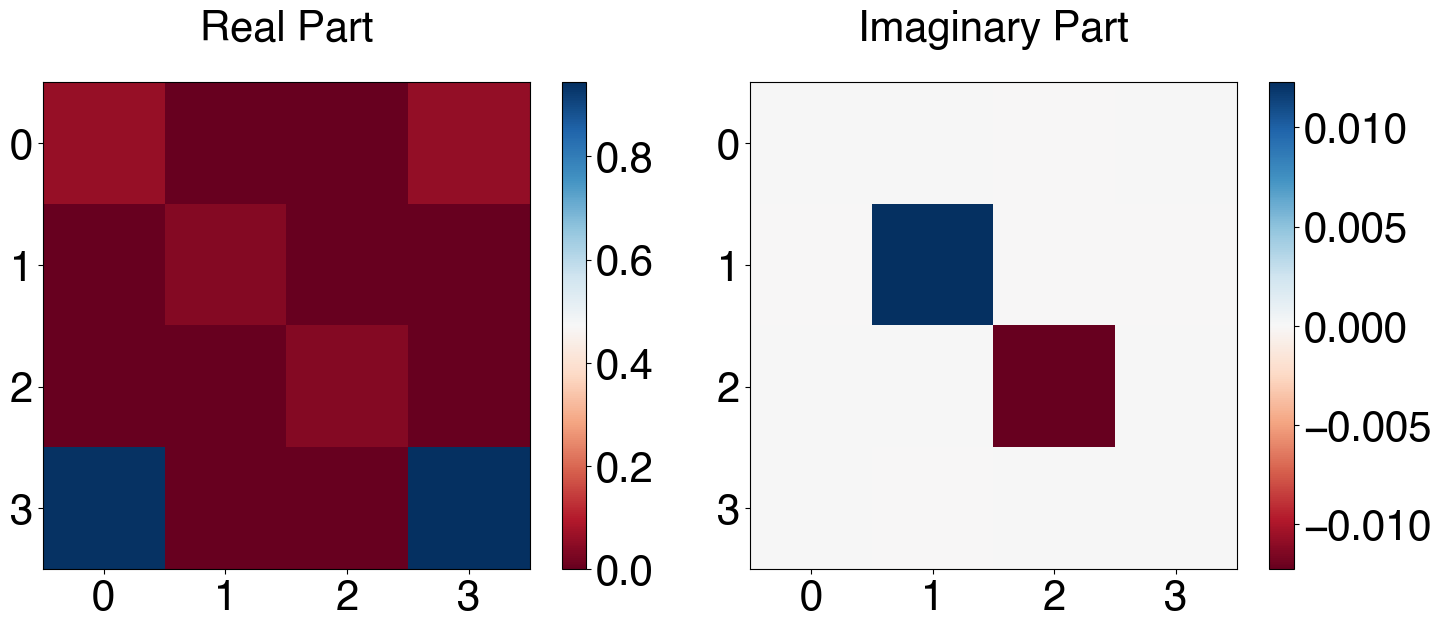

In [41]:
# Create subplots for real and imaginary parts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Convert sparse matrix to dense for plotting
floquet_dense = floquet_super.todense()

# Plot real part
im1 = ax1.imshow(np.real(floquet_dense), cmap='RdBu')
ax1.set_title('Real Part')
plt.colorbar(im1, ax=ax1)
ax1.set_xticks(range(4))
ax1.set_yticks(range(4))

# Plot imaginary part
im2 = ax2.imshow(np.imag(floquet_dense), cmap='RdBu')
ax2.set_title('Imaginary Part')
plt.colorbar(im2, ax=ax2)
ax2.set_xticks(range(4))
ax2.set_yticks(range(4))

plt.tight_layout()
plt.show()

In [42]:
# Eigenvalues and eigenstates of Floquet super operator

eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())

# Eigenstats with eigenvalue closest to 1
idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
steady_state_vec = eigenvecs[:, idx_closest_to_1]
steady_state_mat = vqe._unvectorize(steady_state_vec)
steady_state_mat /= np.trace(steady_state_mat)  # Normalize

from scipy.linalg import eigh
print("Eigenvalues of steady state from Floquet :", eigh(steady_state_mat)[0])
print("Eigenvalues of steady state from VQE     :", eigh(rho_hist_L_1[-1])[0])
print("Floquet super operator steady state matrix:", floquet_super.todense())
print("VQE steady state matrix:", rho_hist_L_1[-1])

Eigenvalues of steady state from Floquet : [0.05693055 0.94306945]
Eigenvalues of steady state from VQE     : [0.05703823 0.94296177]
Floquet super operator steady state matrix: [[ 6.06690309e-02+0.00000000e+00j -5.36428938e-08+1.68031211e-07j
  -5.36428938e-08-1.68031211e-07j  5.67048636e-02+0.00000000e+00j]
 [ 0.00000000e+00-1.92714433e-06j  3.84456195e-02+1.22735191e-02j
   3.68538094e-13-1.17653439e-13j  0.00000000e+00-1.94453332e-06j]
 [ 0.00000000e+00+1.92714433e-06j  3.68538094e-13+1.17653439e-13j
   3.84456195e-02-1.22735191e-02j  0.00000000e+00+1.94453332e-06j]
 [ 9.39330969e-01+0.00000000e+00j  5.36428938e-08-1.68031211e-07j
   5.36428938e-08+1.68031211e-07j  9.43295136e-01+0.00000000e+00j]]
VQE steady state matrix: [[ 5.70385113e-02+5.95750933e-21j -4.39412978e-04-2.37495010e-04j]
 [-4.39412978e-04+2.37495010e-04j  9.42961489e-01+9.90773478e-20j]]


# Stability analysis

## Eigu

In [36]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-10):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger

In [37]:
# Checking if the Floquet super operator is unitary
if is_unitary(floquet_super.toarray()):
    print("Floquet super operator is unitary.")
else:
    print("Floquet super operator is not unitary.")

Floquet super operator is not unitary.


In [43]:
np.sort(np.linalg.eig(floquet_super.todense())[0])

array([0.00396417+3.25894996e-18j, 0.03844562-1.22735191e-02j,
       0.03844562+1.22735191e-02j, 1.        -5.42735430e-18j])

## Cost as a function of $\theta_{\mathrm{exc}}$ $\theta_{\mathrm{dep}}$

In [54]:
# Plot a heatmap of cost function as a function of angles
def cost_function(x, z, Delta):
     return x**2 - z * Delta

def softplus(x):
     """Softplus function to ensure positive angles."""
     return np.log(1 + np.exp(x))

# These does not have to be positive since softplus is used.
theta_exc_range = np.linspace(-1, 20, 100)
theta_dep_range = np.linspace(-1, 20, 100)
theta_exc_mesh, theta_dep_mesh = np.meshgrid(theta_exc_range, theta_dep_range)

last_layer_best_angles_from_optimization = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
best_rho_from_optimization = rho_hist[-1]

perturbed_angles_lst = last_layer_best_angles_from_optimization

cost_values = np.zeros_like(theta_exc_mesh)
for i in range(len(theta_exc_range)):
     for j in range(len(theta_dep_range)):
          # th_f, th_exc, th_int, th_dep 
          perturbed_angles_lst[1] = theta_exc_range[i]
          perturbed_angles_lst[3] = theta_dep_range[j]
          floquet_super = construct_floquet_super(perturbed_angles_lst, best_rho_from_optimization, DELTA, GAMMA_DEPOL, USE_DISSIPATORS)     
          eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())
          idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
          steady_state_vec = eigenvecs[:, idx_closest_to_1]
          # Normalize the steady state vector
          steady_state_vec /= np.linalg.norm(steady_state_vec)
          steady_state_mat = vqe._unvectorize(steady_state_vec)
          steady_state_mat /= np.trace(steady_state_mat)  # Normalize
          x, y, z = vqe._bloch(steady_state_mat)     
          cost_values[i,j] = cost_function(x, z, DELTA)    

Best numerical cost from L + 1 layer: 0.4429622610698813
Best cost in perturbed angles: 0.44345656888170915


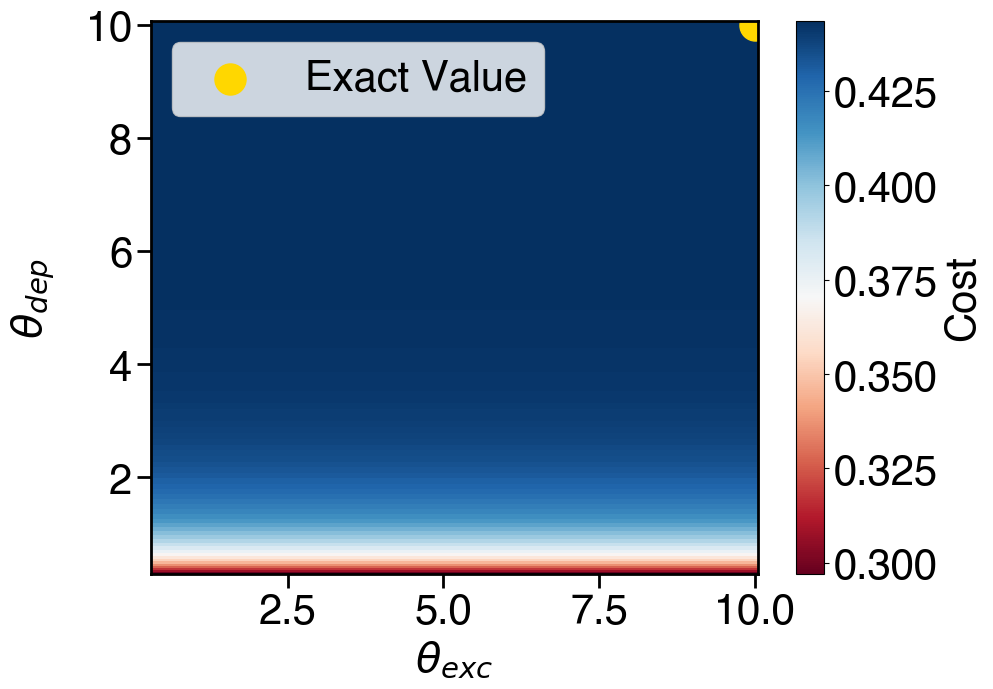

In [53]:
print("Best numerical cost from L + 1 layer:", best_cost_L_1)
print("Best cost in perturbed angles:", np.max(cost_values))
fig, ax = plt.subplots(figsize=(10, 7))
# Use softplus to ensure positive angles.
c = ax.pcolormesh(softplus(theta_exc_mesh), softplus(theta_dep_mesh), cost_values, cmap='RdBu', shading='auto')

# Plot exact values of θ_exc and θ_dep
exact_theta_exc = last_layer_best_angles_from_optimization[1]
exact_theta_dep = last_layer_best_angles_from_optimization[3]
plt.scatter(softplus(exact_theta_exc), softplus(exact_theta_dep), color='gold', s=500, label='Exact Value')
plt.legend(loc = 'upper left')
plt.colorbar(c, label='Cost')
plt.xlabel(r'$\theta_{exc}$', fontsize=med)
plt.ylabel(r'$\theta_{dep}$', labelpad=20, fontsize=med)
for spline in ax.spines.values():
        spline.set_linewidth(2)
        ax.tick_params(axis='both', which='both', length=10, width=2)
plt.tight_layout()
plt.show()

## Cost as a function of $\theta_{\mathrm{exc}}$

In [ ]:
# Plot a heatmap of cost function as a function of angles
def cost_function(x, z, Delta):
     return x**2 - z * Delta

theta_exc_range = np.linspace(-10, 10, 30)

last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
print("Last layer best angles:", last_layer_best_angles)
perturbed_angles_lst = last_layer_best_angles

cost_values = np.zeros_like(theta_exc_range)

for theta_exc_idx in range(len(theta_exc_range)):
          # th_f, th_exc, th_int, th_dep 
          perturbed_angles_lst[1] = theta_exc_range[theta_exc_idx]

          floquet_super = construct_floquet_super(perturbed_angles_lst, rho_hist[-1], DELTA, GAMMA_DEPOL, USE_DISSIPATORS)     
          eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())
          idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
          steady_state_vec = eigenvecs[:, idx_closest_to_1]
          steady_state_mat = vqe._unvectorize(steady_state_vec)
          steady_state_mat /= np.trace(steady_state_mat)  # Normalize
          x, y, z = vqe._bloch(steady_state_mat)     
          cost_values[theta_exc_idx] = cost_function(x, z, DELTA)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(softplus(theta_exc_range), cost_values, marker='o', linestyle='-', color='C0', linewidth=3, markersize=10, label='Cost')
plt.xlabel(r'$\theta_{exc}$')
plt.ylabel('Cost', labelpad=20)
plt.legend()
for spline in ax.spines.values():
        spline.set_linewidth(2)
last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
exact_theta_exc = last_layer_best_angles[1]
plt.axvline(exact_theta_exc, color='C2', linestyle='--', label=f'Exact = {exact_theta_exc:.4f}')
plt.legend()
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/figures/'
# os.chdir(path)
# plt.savefig(f'unitary_floquet_n_layers_3_epsilon_{epsilon}_cost_vs_excitation_angle.png', dpi=600, bbox_inches='tight')        
plt.show()

## Cost as a function of $\theta_{\mathrm{dep}}$

In [ ]:
# Plot a heatmap of cost function as a function of angles
def cost_function(x, z, Delta):
     return x**2 - z * Delta

theta_dep_range = np.linspace(-10, 10, 20)

last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
print("Last layer best angles:", last_layer_best_angles)
perturbed_angles_lst = last_layer_best_angles

cost_values = np.zeros_like(theta_dep_range)

for theta_dep_idx in range(len(theta_dep_range)):
          # th_f, th_exc, th_int, th_dep 
          perturbed_angles_lst[3] = theta_dep_range[theta_dep_idx]

          floquet_super = construct_floquet_super(perturbed_angles_lst, rho_hist[-1], DELTA, GAMMA_DEPOL, USE_DISSIPATORS)     
          eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())
          idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
          steady_state_vec = eigenvecs[:, idx_closest_to_1]
          steady_state_mat = vqe._unvectorize(steady_state_vec)
          steady_state_mat /= np.trace(steady_state_mat)  # Normalize
          x, y, z = vqe._bloch(steady_state_mat)     
          cost_values[theta_dep_idx] = cost_function(x, z, DELTA)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(softplus(theta_dep_range), cost_values, marker='o', linestyle='-', color='C0', linewidth=3, markersize=10, label='Cost')
plt.xlabel(r'$\theta_{dep}$')
plt.ylabel('Cost', labelpad=20)
plt.legend()
for spline in ax.spines.values():
        spline.set_linewidth(2)
last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
exact_theta_dep = last_layer_best_angles[1]
plt.axvline(exact_theta_dep, color='C2', linestyle='--', label=f'Exact = {exact_theta_dep:.5f}')
plt.legend()
# path = '/Users/sasankadowarah/Ultimate_QM_MM/VQA/infinite_ranged_modular/figures/'
# os.chdir(path)
# plt.savefig(f'unitary_floquet_n_layers_3_epsilon_{epsilon}_cost_vs_excitation_angle.png', dpi=600, bbox_inches='tight')        
plt.show()

## Cost as a function of $\theta_{Z}$

In [ ]:
# Plot a heatmap of cost function as a function of angles
def cost_function(x, z, Delta):
     return x**2 - z * Delta

theta_Z_range = np.linspace(-10, 10, 50)

last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
print("Last layer best angles:", last_layer_best_angles)
perturbed_angles_lst = last_layer_best_angles

cost_values = np.zeros_like(theta_Z_range)

for theta_Z_idx in range(len(theta_Z_range)):
          # th_f, th_exc, th_int, th_dep 
          perturbed_angles_lst[0] = theta_Z_range[theta_Z_idx]

          floquet_super = construct_floquet_super(perturbed_angles_lst, rho_hist[-1], DELTA, GAMMA_DEPOL, USE_DISSIPATORS)     
          eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())
          idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
          steady_state_vec = eigenvecs[:, idx_closest_to_1]
          steady_state_mat = vqe._unvectorize(steady_state_vec)
          steady_state_mat /= np.trace(steady_state_mat)  # Normalize
          x, y, z = vqe._bloch(steady_state_mat)     
          cost_values[theta_Z_idx] = cost_function(x, z, DELTA)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(theta_Z_range, cost_values, marker='o', linestyle='-', color='C0', linewidth=3, markersize=10, label='Cost')
plt.xlabel(r'$\theta_{Z}$')
plt.ylabel('Cost', labelpad=20)
plt.legend()
for spline in ax.spines.values():
     spline.set_linewidth(2)
last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
exact_theta_Z = last_layer_best_angles[0]
plt.axvline(exact_theta_Z, color='C2', linestyle='--', label=f'Exact = {exact_theta_Z:.5f}')
plt.legend()
plt.show()

In [ ]:
# Plot a heatmap of cost function as a function of angles
def cost_function(x, z, Delta):
     return x**2 - z * Delta

theta_X_range = np.linspace(-5, 5, 50)

last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
print("Last layer best angles:", last_layer_best_angles)
perturbed_angles_lst = last_layer_best_angles

cost_values = np.zeros_like(theta_X_range)

for theta_X_idx in range(len(theta_X_range)):
          # th_f, th_exc, th_int, th_dep 
          perturbed_angles_lst[2] = theta_X_range[theta_X_idx]

          floquet_super = construct_floquet_super(perturbed_angles_lst, rho_hist[-1], DELTA, GAMMA_DEPOL, USE_DISSIPATORS)     
          eigenvals, eigenvecs = np.linalg.eig(floquet_super.todense())
          idx_closest_to_1 = np.argmin(np.abs(eigenvals - 1))
          steady_state_vec = eigenvecs[:, idx_closest_to_1]
          steady_state_mat = vqe._unvectorize(steady_state_vec)
          steady_state_mat /= np.trace(steady_state_mat)  # Normalize
          x, y, z = vqe._bloch(steady_state_mat)     
          cost_values[theta_X_idx] = cost_function(x, z, DELTA)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(theta_X_range, cost_values, marker='o', linestyle='-', color='C0', linewidth=3, markersize=10, label='Cost')
plt.xlabel(r'$\theta_{X}$')
plt.ylabel('Cost', labelpad=20)
plt.legend()
for spline in ax.spines.values():
     spline.set_linewidth(2)
last_layer_best_angles = (np.array(angles_hist)[-1][-1:,]).tolist()[0]
exact_theta_X = last_layer_best_angles[2]
plt.axvline(exact_theta_X, color='C2', linestyle='--', label=f'Exact = {exact_theta_X:.5f}')
plt.legend()
plt.show()